In [1]:
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
DB_HOST = "localhost"
DB_NAME = "postgres"  
DB_USER = "postgres" 
DB_PASS = "dessa1907"


query = """
SELECT
    t1.participants_id,    
    t1.age,
    t1.pregnancies,

    t2.participants_id,   
    t2.glucose,
    t2.bloodpressure,
    t2.bmi,
    t2.outcome,

    ABS(EXTRACT(EPOCH FROM (
    CASE
        WHEN t3.first_meal_time < t3.last_meal_time THEN (t3.first_meal_time + interval '24 hours') - t3.last_meal_time
        ELSE t3.first_meal_time - t3.last_meal_time
    END
))) / 3600 AS fasting_duration_hours  -- Fasting duration in hours

FROM
    participants t1   
INNER JOIN
    metabolic_measurements t2 ON t1.participants_id = t2.participants_id  -- metabolic measurements table
INNER JOIN
    fasting_info t3 ON t1.participants_id = t3.participants_id;
    """

conn = psycopg2.connect(host=DB_HOST, database=DB_NAME, user=DB_USER, password=DB_PASS)

In [15]:
df = pd.read_sql(query, conn)

C:\Users\Usuário\AppData\Local\Temp\ipykernel_16360\1168034203.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [16]:
df.head()

,participants_id,age,pregnancies,participants_id,glucose,bloodpressure,bmi,outcome,fasting_duration_hours
0,1,50,6,1,148,72,33.6,1,14.0
1,2,31,1,2,85,66,26.6,0,14.0
2,3,32,8,3,183,64,23.3,1,8.0
3,4,21,1,4,89,66,28.1,0,8.0
4,5,33,0,5,137,40,43.1,1,14.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   participants_id         768 non-null    int64  
 1   age                     768 non-null    int64  
 2   pregnancies             768 non-null    int64  
 3   participants_id         768 non-null    int64  
 4   glucose                 768 non-null    int64  
 5   bloodpressure           768 non-null    int64  
 6   bmi                     768 non-null    float64
 7   outcome                 768 non-null    int64  
 8   fasting_duration_hours  768 non-null    float64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Explanatory Data Analysis (EDA)

In [18]:
df.describe()

,participants_id,age,pregnancies,participants_id,glucose,bloodpressure,bmi,outcome,fasting_duration_hours
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,384.500000,33.240885,3.845052,384.500000,120.894531,69.105469,31.992578,0.348958,12.187500
std,221.846794,11.760232,3.369578,221.846794,31.972618,19.355807,7.884160,0.476951,2.756762
min,1.000000,21.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000
25%,192.750000,24.000000,1.000000,192.750000,99.000000,62.000000,27.300000,0.000000,8.000000
50%,384.500000,29.000000,3.000000,384.500000,117.000000,72.000000,32.000000,0.000000,14.000000
75%,576.250000,41.000000,6.000000,576.250000,140.250000,80.000000,36.600000,1.000000,14.000000
max,768.000000,81.000000,17.000000,768.000000,199.000000,122.000000,67.100000,1.000000,14.000000


In [19]:
df.fasting_duration_hours.describe()

count    768.000000
mean      12.187500
std        2.756762
min        8.000000
25%        8.000000
50%       14.000000
75%       14.000000
max       14.000000
Name: fasting_duration_hours, dtype: float64

Text(0.5, 1.0, 'Distribution of Fasting Duration (hours)')

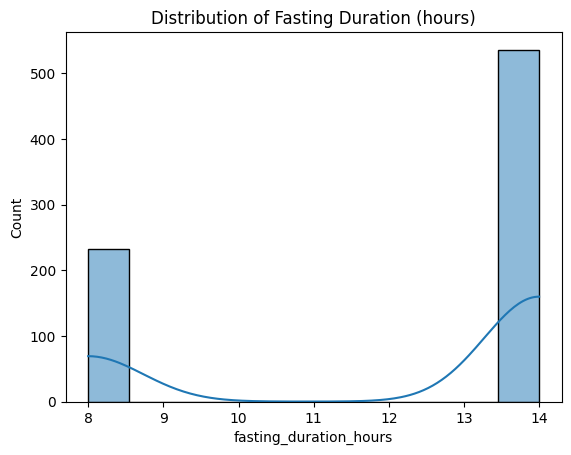

In [20]:
sns.histplot(df['fasting_duration_hours'], kde=True)
plt.title('Distribution of Fasting Duration (hours)')

Biomodal Distribution: peak 1 (short fasting - 8h) and peak 2 (long fasting - 12h). Most participants are divided in these two groups. Just a few participants fast between 10 to 12 hours.

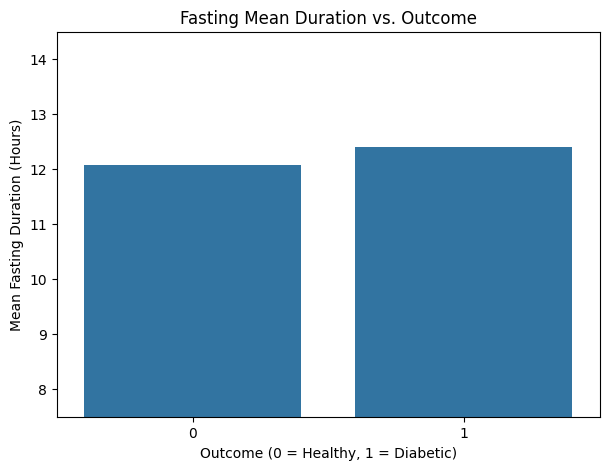

In [24]:
# Fasting mean duration by outcome
df_mean_fasting = df.groupby('outcome')['fasting_duration_hours'].mean().reset_index()

# Plotting
plt.figure(figsize=(7, 5))
sns.barplot(x='outcome', y='fasting_duration_hours', data=df_mean_fasting)

plt.title('Fasting Mean Duration vs. Outcome')
plt.xlabel('Outcome (0 = Healthy, 1 = Diabetic)')
plt.ylabel('Mean Fasting Duration (Hours)')
plt.ylim(7.5, 14.5) # Adjust Y-axis to zoom in on data
plt.show()

In this situation, the mean was not a good parameter, which confirms the finding above: the dataset is divided by two main groups - 8h and 12h fasting.

C:\Users\Usuário\AppData\Local\Temp\ipykernel_16360\3253100797.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fasting_risk = df.groupby('fasting_group')['outcome'].mean().reset_index()


Diabetes Risk by Fasting Group:
     fasting_group  Risk_Percentage
0     Short (<10h)        30.603448
1  Medium (10-13h)              NaN
2      Long (>13h)        36.753731


C:\Users\Usuário\AppData\Local\Temp\ipykernel_16360\3253100797.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fasting_group', y='Risk_Percentage', data=fasting_risk, palette='viridis')


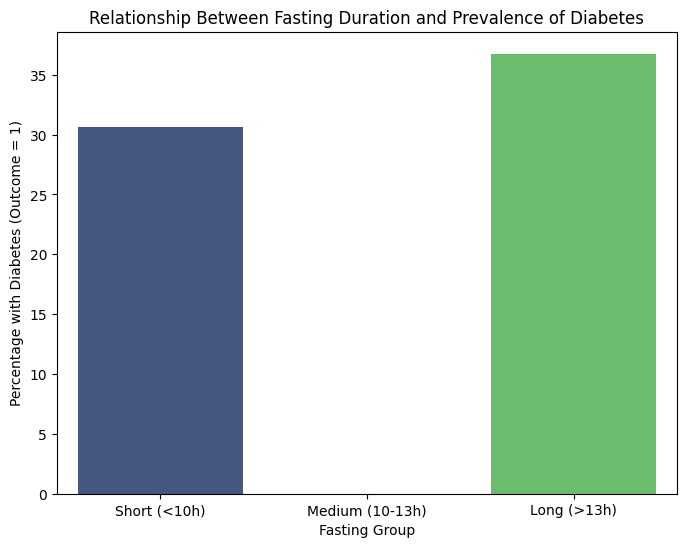

In [26]:
# Define bins and labels for fasting duration groups
bins = [0, 10, 13, 24] # 0 to 10h, 10h to 13h, 13h to 24h
labels = ['Short (<10h)', 'Medium (10-13h)', 'Long (>13h)']

# 2. Create the new categorical column (Fast_Group)
df['fasting_group'] = pd.cut(
    df['fasting_duration_hours'], 
    bins=bins, 
    labels=labels, 
    right=False # Define the lower bound as inclusive
)

# 3. Calculate the Proportion of Diabetics (Outcome = 1) in each group
# This uses the group size to calculate the percentage of '1's
fasting_risk = df.groupby('fasting_group')['outcome'].mean().reset_index()

# Rename the column for clarity
fasting_risk.rename(columns={'outcome': 'Risk_Percentage'}, inplace=True)
fasting_risk['Risk_Percentage'] = fasting_risk['Risk_Percentage'] * 100

print("Diabetes Risk by Fasting Group:")
print(fasting_risk)

# 4. Plot the Risk (Bar Chart)
plt.figure(figsize=(8, 6))
sns.barplot(x='fasting_group', y='Risk_Percentage', data=fasting_risk, palette='viridis')
plt.title('Relationship Between Fasting Duration and Prevalence of Diabetes')
plt.xlabel('Fasting Group')
plt.ylabel('Percentage with Diabetes (Outcome = 1)')
plt.show()

The graph reveals that the prevalence of diabetes is significantly higher in the group engaging in prolonged fasting (above 13 hours). This observed correlation may be a result of targeted clinical intervention or individual attempts to achieve better glycemic control by extending fasting windows.

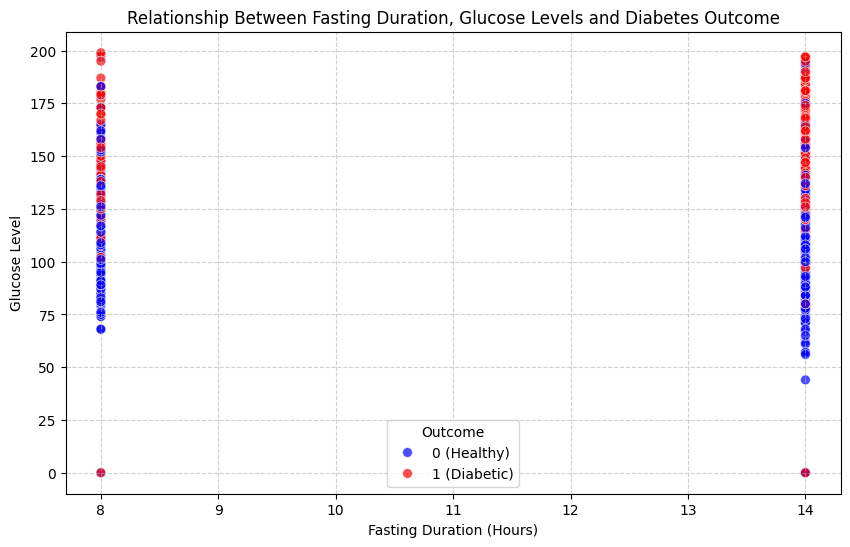

In [35]:
plt.figure(figsize=(10, 6))

custom_palette = {0: 'blue', 1: 'red'} 

sns.scatterplot(
    x='fasting_duration_hours',
    y='glucose',
    hue='outcome',         
    data=df,
    palette=custom_palette, 
    s=50,                   
    alpha=0.7              
)

plt.title('Relationship Between Fasting Duration, Glucose Levels and Diabetes Outcome')
plt.xlabel('Fasting Duration (Hours)')
plt.ylabel('Glucose Level')
plt.grid(True, linestyle='--', alpha=0.6)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['0 (Healthy)', '1 (Diabetic)']
plt.legend(handles, new_labels, title='Outcome')
plt.show()

The last scatter plot confirmed that Glucose Level is the strongest predictive factor for the diabetes outcome, given the clear vertical separation between the Diabetic and Healthy groups. Fasting Duration, although showing two distinct clusters (~8h and ~14h), functions as a secondary risk indicator, showing a slightly higher concentration of Diabetic cases in the Long Fasting group.

**Next Step: Machine Learning**

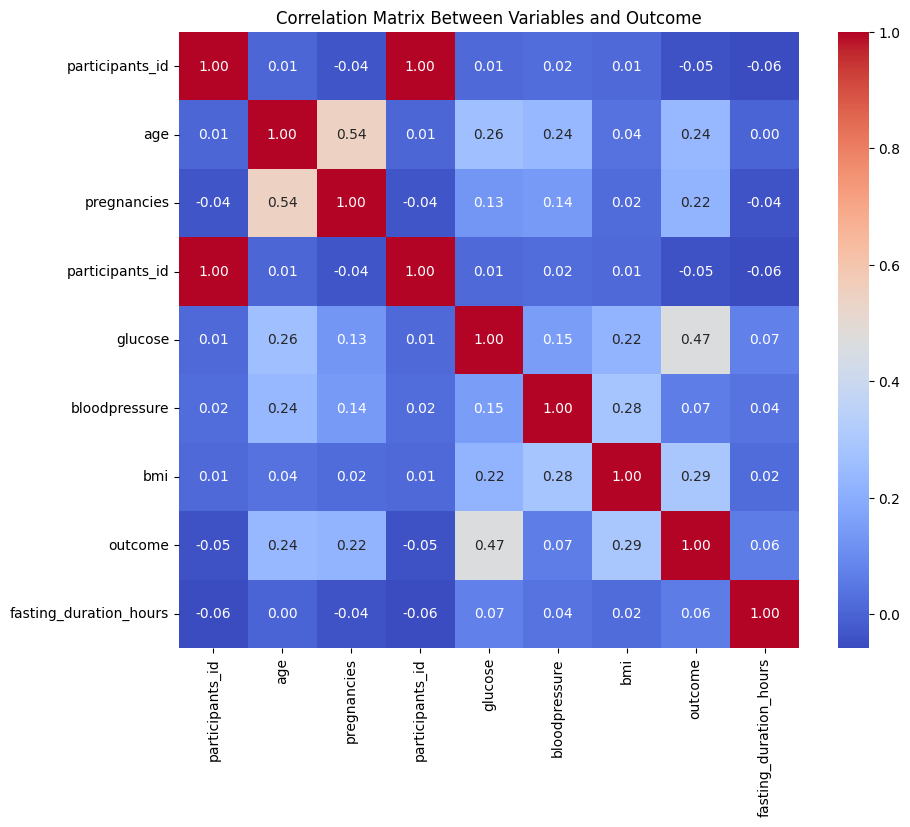

In [38]:
# Creating a correlation matrix (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Between Variables and Outcome')
plt.show()

Exploratory Data Analysis (EDA) revealed that Glucose Level is the strongest predictor for diabetes diagnosis, showing the highest correlation with the outcome (0.47). BMI (0.29), Age (0.26), and Number of Pregnancies (0.22) follow as relevant secondary predictors. Although the data engineering feature, fasting_duration_hours, showed an interesting bimodal distribution and a subtly higher prevalence of diabetes in the long fasting group, its linear correlation with the outcome is the weakest (0.06). Therefore, the Machine Learning model should focus on the first four features for maximum accuracy, using fasting duration as a complementary risk factor, whose relevance can be better explored by non-linear algorithms.

In [39]:

from sklearn.model_selection import train_test_split

# Define Features (X) e o Target (y)
features = [
    'glucose',          # 0.47
    'bmi',              # 0.29
    'age',              # 0.26
    'pregnancies',      # 0.22
    'fasting_duration_hours' # 0.06 (kept for being the new feature of the project)
    # bloodpressure excluded - weak correlation (0.07)
]

X = df[features]  # Feature Matrix
y = df['outcome'] # Target Vector

# Divide the data into Training and Testing sets
# 80% for Training (for the model to learn) and 20% for Testing (for the model to be evaluated)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20,       # 20% for testing
    random_state=42,      # Ensures the split is the same every time (reproducibility)
    stratify=y            # Ensures the proportion of 0 and 1 in 'y' is maintained in both sets
)

# Checking results of the split
print("Dimensions of Original Dataset:", df.shape)
print("Dimensions of X_train (Training):", X_train.shape)
print("Dimensions of X_test (Testing):", X_test.shape)
print("Proportion of outcome in y_train:")
print(y_train.value_counts(normalize=True))

Dimensions of Original Dataset: (768, 10)
Dimensions of X_train (Training): (614, 5)
Dimensions of X_test (Testing): (154, 5)
Proportion of outcome in y_train:
outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64


Accuracy: 0.7207792207792207
Precision: 0.6122448979591837
Recall: 0.5555555555555556
F1 Score: 0.5825242718446602


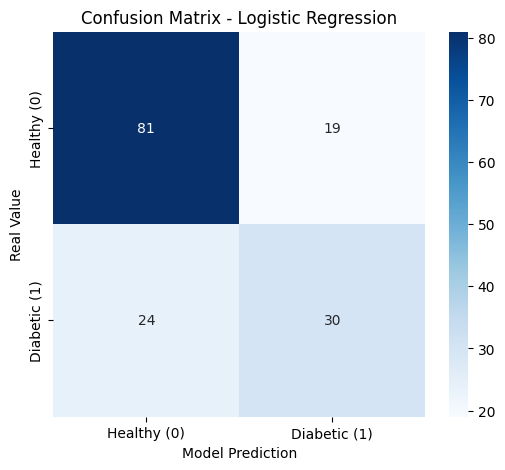

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_model = LogisticRegression(random_state=42, max_iter=200)
log_model.fit(X_train, y_train)
y_pred_model = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_model))
print("Precision:", precision_score(y_test, y_pred_model))
print("Recall:", recall_score(y_test, y_pred_model))
print("F1 Score:", f1_score(y_test, y_pred_model))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

cm_log = confusion_matrix(y_test, y_pred_model)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy (0)', 'Diabetic (1)'], 
            yticklabels=['Healthy (0)', 'Diabetic (1)'])
plt.xlabel('Model Prediction')
plt.ylabel('Real Value')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Logistic Regression is a good baseline model, achieving 72.1% accuracy. However, the recall of only 55.6% and the 24 false negatives indicate that the model is not reliable enough for a risk diagnosis, as it is missing almost half (44.4%) of the actual cases of diabetes.

**Comparing Logistic Regression, Decision Tree and Random Forest**

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=200),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

# Training Loop and Evaluation
print("Training and Evaluation of 3 Models...\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }
    
    print(f"✅ {name} trained and evaluated.")


# DataFrame for easy comparison
results_df = pd.DataFrame(results).T
print("\n--- Model Comparison Table (20% Test) ---")
print(results_df.round(3))

Training and Evaluation of 3 Models...

✅ Logistic Regression trained and evaluated.
✅ Decision Tree trained and evaluated.
✅ Random Forest trained and evaluated.

--- Model Comparison Table (20% Test) ---
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression     0.721      0.612   0.556     0.583
Decision Tree           0.688      0.556   0.556     0.556
Random Forest           0.740      0.652   0.556     0.600


**Recall (Critical Point):** The Recall remained at 0.556 for all three models. This means that, regardless of the algorithm, the model is still missing 44.4% of the actual cases of diabetes (False Negatives), using the current features and standard calibration. 
**Accuracy and Precision:** The Random Forest model achieved the best overall performance, with the highest accuracy (0.740) and the highest precision (0.667).
**Decision Tree:** it was the worst, with the lowest accuracy and precision.

Inicializing Grid Search to maximaze Recall...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Better Recall Found: 0.566
✅ Better Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

--- Optimized Random Forest ---
Recall Test: 0.611


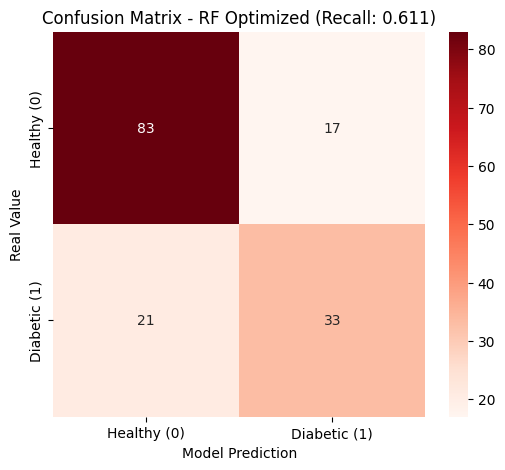

In [46]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, confusion_matrix

# Parameters to be tested in Grid Search
param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [5, 10, None], 
    'min_samples_split': [2, 5], 
    'criterion': ['gini', 'entropy'] 
}

# Inicialize the Model  
rf = RandomForestClassifier(random_state=42)

#Grid Search Initialization
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    scoring='recall', 
    cv=5, # Cross-Validation  5 folds
    verbose=1, 
    n_jobs=-1
)

# Otimization Execution on Training Set
print("Inicializing Grid Search to maximaze Recall...")
grid_search.fit(X_train, y_train)

# Better parameters and model
best_rf = grid_search.best_estimator_
print(f"\n✅ Better Recall Found: {grid_search.best_score_:.3f}")
print(f"✅ Better Parameters: {grid_search.best_params_}")

# Making Predictions
y_pred_tuned = best_rf.predict(X_test)

# Evaluate Recall and Confusion Matrix of the Optimized Model
recall_tuned = recall_score(y_test, y_pred_tuned)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

print(f"\n--- Optimized Random Forest ---")
print(f"Recall Test: {recall_tuned:.3f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Healthy (0)', 'Diabetic (1)'], 
            yticklabels=['Healthy (0)', 'Diabetic (1)'])
plt.xlabel('Model Prediction')
plt.ylabel('Real Value')
plt.title(f'Confusion Matrix - RF Optimized (Recall: {recall_tuned:.3f})')
plt.show()

Optimizing the **Random Forest model with Grid Search** to maximize Recall was a success. The Recall on the test set improved to 0.611 (up from 0.556 in the base models). Crucially, the optimized model reduced the False Negatives (where diabetes is missed) from 24 to 21, proving that hyperparameter tuning resulted in a safer and more effective classifier for detecting diabetes risk.